# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [28]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [67]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

### Device

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [69]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Model

In [70]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [71]:
class ComplexConvNet(nn.Module):
    def __init__(self):
        super(ComplexConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
model = ConvNet()
# model = ComplexConvNet()
model.to(device)


ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [73]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        return focal_loss.mean()

In [66]:
##################### Write your answer here ##################
# MAE loss
# criterion = nn.L1Loss()

# CE loss
# criterion = nn.CrossEntropyLoss()

# Focal loss
# criterion = FocalLoss(gamma=0.5)

criterion = FocalLoss(gamma=2)
###############################################################

In [56]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    
    # L1Loss adjust
#     target = target.view(-1,1)
    
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [57]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    
     # L1Loss adjust
#     target = target.view(-1,1)
    
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [74]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0109 Acc: 0.2839
Begin test......
Test Loss: 0.0096 Acc: 0.3554
Epoch: 2/30 Train Loss: 0.0098 Acc: 0.3383
Begin test......
Test Loss: 0.0095 Acc: 0.3282
Epoch: 3/30 Train Loss: 0.0097 Acc: 0.3476
Begin test......
Test Loss: 0.0094 Acc: 0.3759
Epoch: 4/30 Train Loss: 0.0095 Acc: 0.3667
Begin test......
Test Loss: 0.0089 Acc: 0.3936
Epoch: 5/30 Train Loss: 0.0096 Acc: 0.3625
Begin test......
Test Loss: 0.0087 Acc: 0.3998
Epoch: 6/30 Train Loss: 0.0086 Acc: 0.4135
Begin test......
Test Loss: 0.0082 Acc: 0.4395
Epoch: 7/30 Train Loss: 0.0084 Acc: 0.4231
Begin test......
Test Loss: 0.0082 Acc: 0.4459
Epoch: 8/30 Train Loss: 0.0083 Acc: 0.4278
Begin test......
Test Loss: 0.0077 Acc: 0.4539
Epoch: 9/30 Train Loss: 0.0082 Acc: 0.4313
Begin test......
Test Loss: 0.0079 Acc: 0.4547
Epoch: 10/30 Train Loss: 0.0081 Acc: 0.4343
Begin test......
Test Loss: 0.0075 Acc: 0.4587
Epoch: 11/30 Train Loss: 0.0077 Acc: 0.4585
Begin test......
Test Loss: 0.0071 Acc: 0.4920
Epoch: 1

In [42]:
CE_training_loss = training_loss
CE_training_acc = training_acc
CE_testing_loss = testing_loss
CE_testing_acc = testing_acc

In [25]:
CE_training_loss_large = training_loss
CE_training_acc_large = training_acc
CE_testing_loss_large = testing_loss
CE_testing_acc_large = testing_acc

In [54]:
L1_training_loss = training_loss
L1_training_acc = training_acc
L1_testing_loss = testing_loss
L1_testing_acc = testing_acc

In [65]:
Fo_h_training_loss = training_loss
Fo_h_training_acc = training_acc
Fo_h_testing_loss = testing_loss
Fo_h_testing_acc = testing_acc

In [75]:
Fo_t_training_loss = training_loss
Fo_t_training_acc = training_acc
Fo_t_testing_loss = testing_loss
Fo_t_testing_acc = testing_acc

L1:
Average Training Loss: 0.017869060729265213
Average Testing Loss: 0.017571011054118475
Average Training Accuracy: 0.09370600000000001
Average Testing Accuracy: 0.08779000000000002


CE:
Average Training Loss: 0.011815390361865363
Average Testing Loss: 0.011201520860592526
Average Training Accuracy: 0.44855266666666677
Average Testing Accuracy: 0.48363333333333336


Focal (gamma=0.5):
Average Training Loss: 0.010482044992168744
Average Testing Loss: 0.009958807524442672
Average Training Accuracy: 0.45549999999999996
Average Testing Accuracy: 0.48573


Focal (gamma=2):
Average Training Loss: 0.007739425778786341
Average Testing Loss: 0.007211770045757293
Average Training Accuracy: 0.45872666666666667
Average Testing Accuracy: 0.4907233333333334




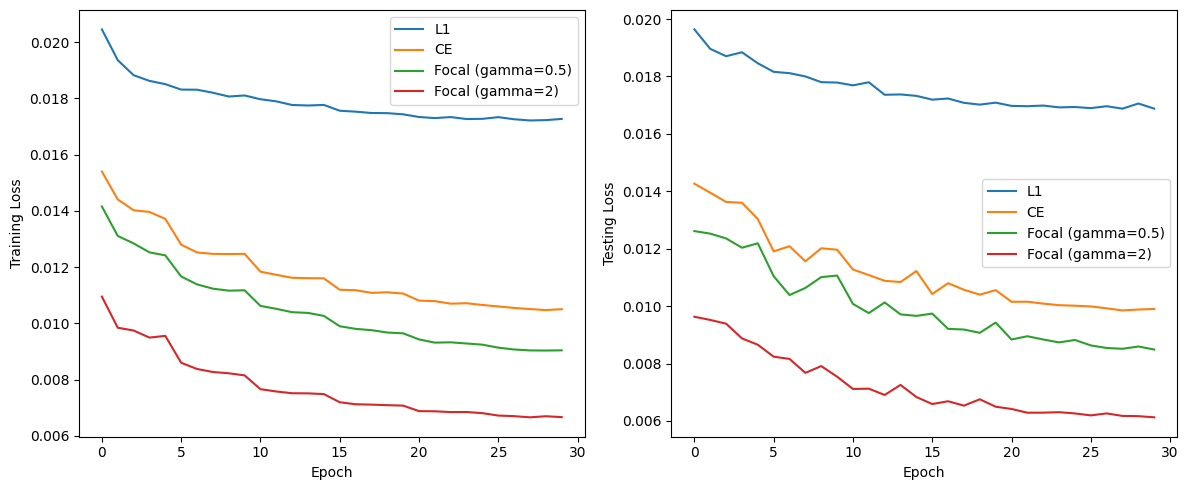

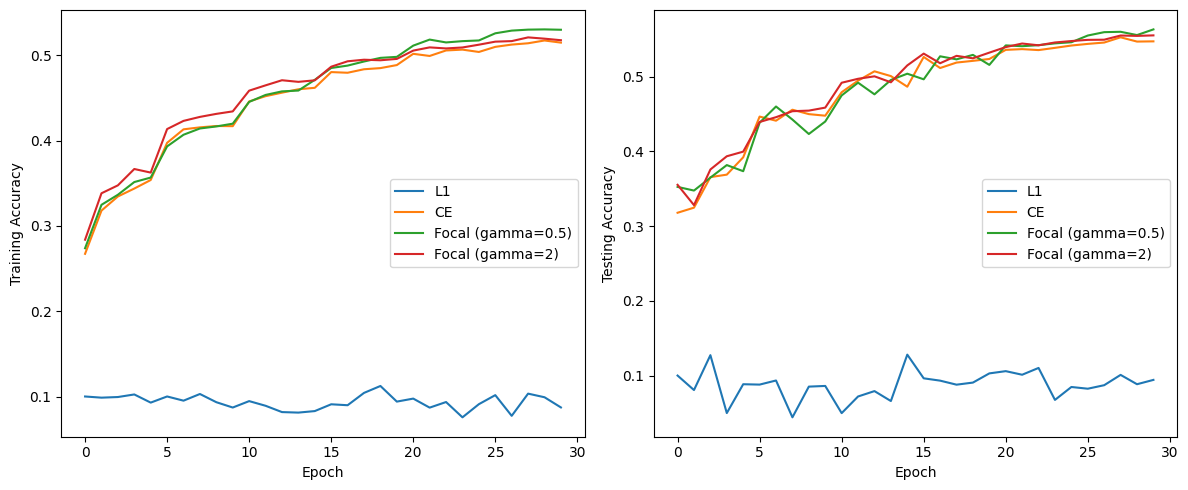

In [76]:
loss_functions = ['L1', 'CE', 'Focal (gamma=0.5)', 'Focal (gamma=2)']
training_loss = [L1_training_loss, CE_training_loss, Fo_h_training_loss, Fo_t_training_loss]
testing_loss = [L1_testing_loss, CE_testing_loss, Fo_h_testing_loss, Fo_t_testing_loss]
training_acc = [L1_training_acc, CE_training_acc, Fo_h_training_acc, Fo_t_training_acc]
testing_acc = [L1_testing_acc, CE_testing_acc, Fo_h_testing_acc, Fo_t_testing_acc]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, loss_function in enumerate(loss_functions):
    plt.plot(training_loss[i], label=loss_function)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i, loss_function in enumerate(loss_functions):
    plt.plot(testing_loss[i], label=loss_function)

plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.tight_layout()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, loss_function in enumerate(loss_functions):
    plt.plot(training_acc[i], label=loss_function)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, loss_function in enumerate(loss_functions):
    plt.plot(testing_acc[i], label=loss_function)

plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.tight_layout()


average_training_loss = [np.mean(l) for l in training_loss]
average_testing_loss = [np.mean(l) for l in testing_loss]
average_training_acc = [np.mean(l) for l in training_acc]
average_testing_acc = [np.mean(l) for l in testing_acc]

for i, loss_function in enumerate(loss_functions):
    print(f'{loss_function}:')
    print(f'Average Training Loss: {average_training_loss[i]}')
    print(f'Average Testing Loss: {average_testing_loss[i]}')
    print(f'Average Training Accuracy: {average_training_acc[i]}')
    print(f'Average Testing Accuracy: {average_testing_acc[i]}')
    print('\n')

plt.show()

simple:
Average Training Loss: 0.01140761501121521
Average Testing Loss: 0.010740429225961365
Average Training Accuracy: 0.4723573333333333
Average Testing Accuracy: 0.50976


complex:
Average Training Loss: 0.005183730895102026
Average Testing Loss: 0.0057528476777672765
Average Training Accuracy: 0.7691053333333335
Average Testing Accuracy: 0.7574400000000002




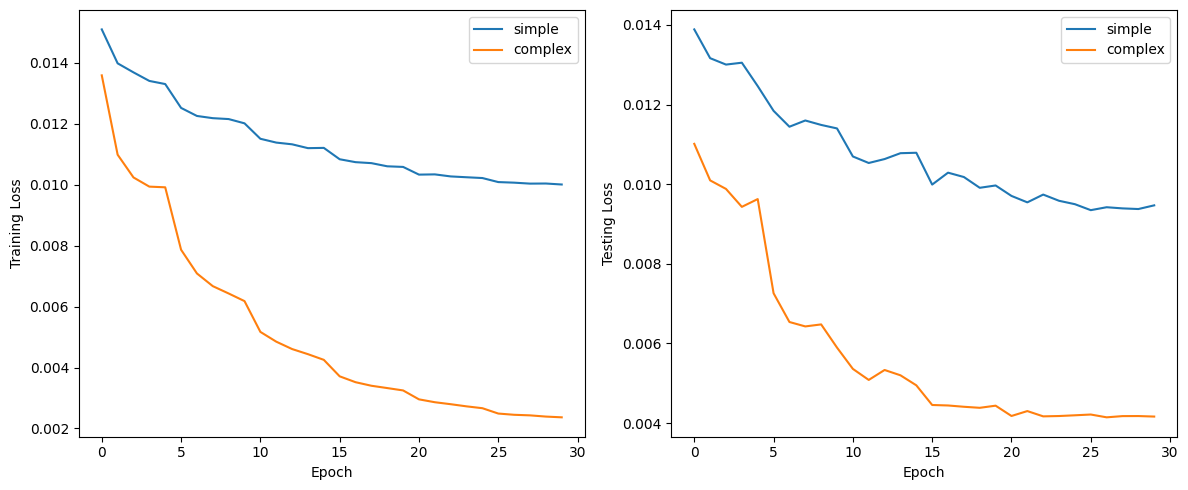

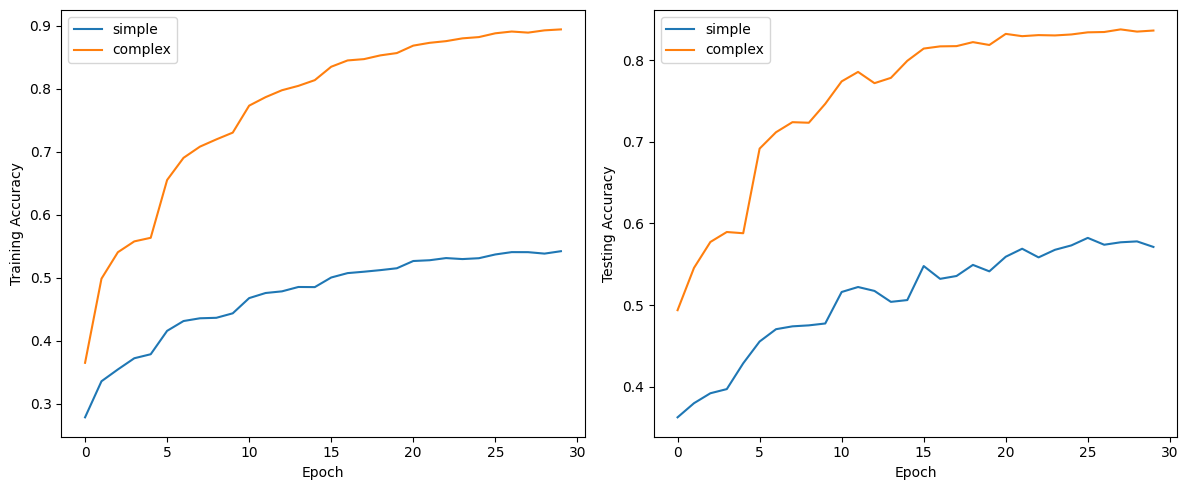

In [27]:
model_size = ["simple","complex"]
training_loss_model = [CE_training_loss, CE_training_loss_large]
testing_loss_model = [CE_testing_loss, CE_testing_loss_large]
training_acc_model = [CE_training_acc, CE_training_acc_large]
testing_acc_model = [CE_testing_acc, CE_testing_acc_large]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, model in enumerate(model_size):
    plt.plot(training_loss_model[i], label=model)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i, model in enumerate(model_size):
    plt.plot(testing_loss_model[i], label=model)

plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.tight_layout()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, model in enumerate(model_size):
    plt.plot(training_acc_model[i], label=model)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, model in enumerate(model_size):
    plt.plot(testing_acc_model[i], label=model)

plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.tight_layout()


average_training_loss_model = [np.mean(l) for l in training_loss_model]
average_testing_loss_model = [np.mean(l) for l in testing_loss_model]
average_training_acc_model = [np.mean(l) for l in training_acc_model]
average_testing_acc_model = [np.mean(l) for l in testing_acc_model]

for i, model in enumerate(model_size):
    print(f'{model}:')
    print(f'Average Training Loss: {average_training_loss_model[i]}')
    print(f'Average Testing Loss: {average_testing_loss_model[i]}')
    print(f'Average Training Accuracy: {average_training_acc_model[i]}')
    print(f'Average Testing Accuracy: {average_testing_acc_model[i]}')
    print('\n')

plt.show()

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [ ]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [ ]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = 
predict_label = 

In [ ]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')